In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision

class VGG16(nn.Module):
    def __init__(self, out_dim, *args, **kwargs):
        super(VGG16, self).__init__(*args, **kwargs)
        vgg16 = torchvision.models.vgg16(pretrained=True)
        self._up_kwargs = {'mode': 'bilinear', 'align_corners': True}
        self.features = vgg16.features
        self.conv1x1 = nn.Conv2d(512, out_dim, 1,1,0)
        self.deconv = nn.ConvTranspose2d(512, out_dim, kernel_size=32, stride=32, padding=0, output_padding=0)
    def forward(self, x):
        imsize = x.size()[2:]
        x =self.features(x)
        x = self.conv1x1(x)
        x = F.upsample(x, imsize, **self._up_kwargs)
        return x



/home/sangeeta/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


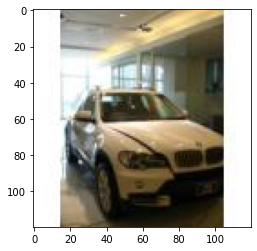

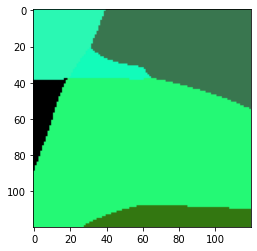

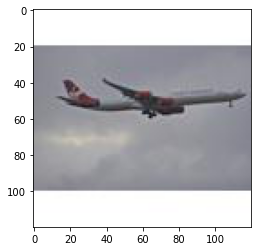

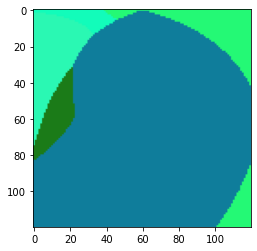

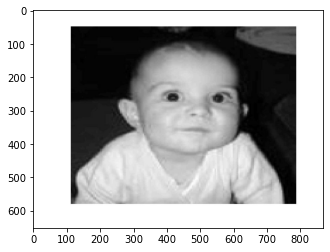

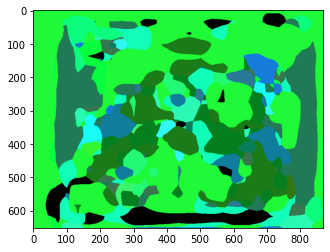

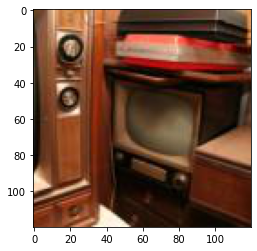

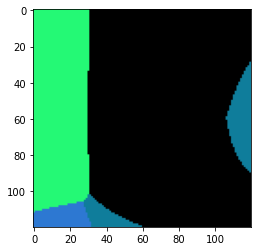

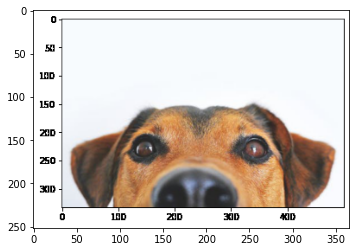

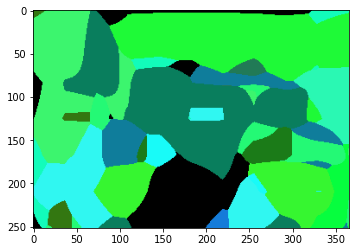

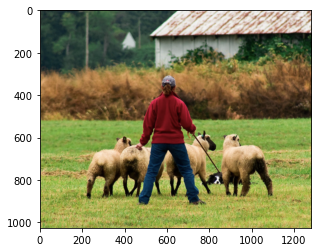

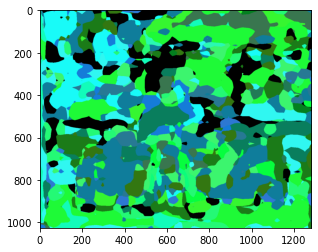

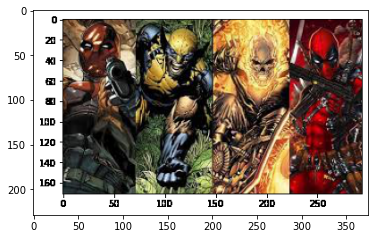

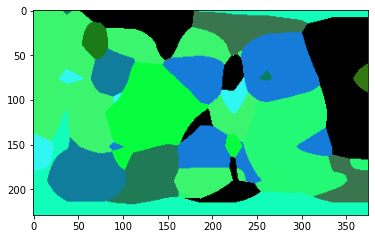

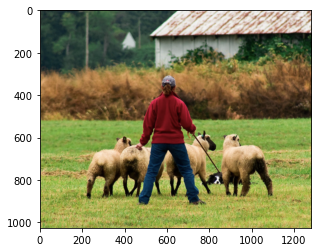

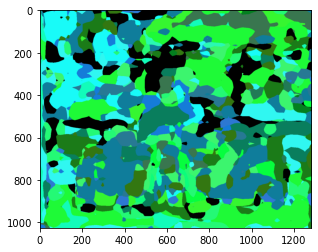

In [2]:
import matplotlib.pyplot as plt
import os
palette = torch.tensor([2 ** 10 - 1, 2 ** 15 - 1,2 ** 21 - 1])
directory = "images/images"
vgg = VGG16(21)
for filename in os.listdir(directory):
    input_image = Image.open(os.path.join(directory, filename))
    input_image = input_image.convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    
    with torch.no_grad():
        output = vgg(input_batch)

    output_predictions = output.argmax(1)
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")


    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions[-1,:].byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)

    
    plt.figure()
    plt.imshow(input_image)
    plt.figure()
    plt.imshow(r)

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
cap = dset.CocoCaptions(root = 'dir where images are',
                        annFile = 'json annotation file',
                        transform=transforms.ToTensor())

ModuleNotFoundError: No module named 'pycocotools'

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [ ]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

# visualize_model(model_conv)

plt.ioff()
plt.show()